In [1]:
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Download Face evolve model files 

#Getting files require to run Face Evolve model based on MTCNN for Face Detection 

!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/align_trans.py -O ./align_trans.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/box_utils.py -O ./box_utils.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/detector.py -O ./detector.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/face_align.py -O ./face_align.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/face_resize.py -O ./face_resize.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/first_stage.py -O ./first_stage.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/get_nets.py -O ./get_nets.py
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/matlab_cp2tform.py -O ./matlab.cpt2tform.py
  
#Getting the weights of three models Onet, Pnet and Rnet 
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/onet.npy -O ./onet.npy
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/pnet.npy -O ./pnet.npy
!wget https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/raw/master/align/rnet.npy -O ./rnet.npy
  
!wget https://raw.githubusercontent.com/ZhaoJ9014/face.evoLVe.PyTorch/master/align/visualization_utils.py -O ./visualization_utils.py


In [0]:
#Main code 

#Colab Imports
from google.colab import files

#Python Imports
from PIL import Image
from detector import detect_faces
import matplotlib.pyplot as plt 
import time
from torch.autograd import Variable
import numpy as np 
import warnings
import torch
import torchvision.transforms as transforms
import random
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings('ignore')

model_path = "/content/drive/My Drive/Siamese/data/faces/testing/model.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
      
      
recognition_model = SiameseNetwork().to(device)
recognition_model.load_state_dict(torch.load(model_path))
recognition_model = recognition_model.to("cpu")
recognition_model = recognition_model.to(device)

def show_batch(batch):
    plt.imshow(np.transpose(batch.numpy(), (1, 2, 0)))
    



def face_comparison(image_path1, image_path2):
  img = Image.open(image_path1)
  first_image = img.resize((255,255), Image.ANTIALIAS) 
  bounding_box = detect_faces(first_image)
  first_image = first_image.crop((bounding_box[0][0][0],bounding_box[0][0][1],bounding_box[0][0][2],bounding_box[0][0][3]))
  first_image = first_image.convert('L')
  t = transforms.ToTensor()
  first_tensor = t(first_image.resize((100,100)))
  first = first_tensor.unsqueeze(0)
  #for the second image
  img2 = Image.open(image_path2)
  second_image = img2.resize((255,255), Image.ANTIALIAS) 
  bounding_box = detect_faces(second_image)
  second_image = second_image.crop((bounding_box[0][0][0],bounding_box[0][0][1],bounding_box[0][0][2],bounding_box[0][0][3]))
  second_image = second_image.convert('L')
  t = transforms.ToTensor()
  second_tensor = t(second_image.resize((100,100)))
  second = second_tensor.unsqueeze(0)
  
  
  concatenated = torch.cat((first,second),0)

  output1,output2 = recognition_model(Variable(first).cuda(),Variable(second).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  print('Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

Hello User! Please upload first image


Saving face10.jpg to face10 (1).jpg
Please upload the second image


Saving face5.jpg to face5 (5).jpg
Calculating the similarity score... Please wait for a moment
Dissimilarity: 0.76


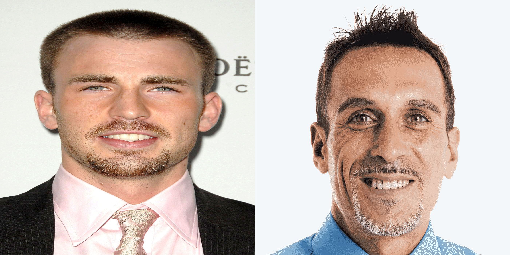

In [48]:
#@title Upload images
#Upload first image

print ('Hello User! Please upload first image')
uploaded = files.upload()
for fn in uploaded.keys():
  first_image_path = "./" + fn
  
  
print ('Please upload the second image')  
#Upload second image
uploaded = files.upload()
for fn in uploaded.keys():
  second_image_path = "./" + fn


  
  
print ('Calculating the similarity score... Please wait for a moment')

face_comparison(first_image_path, second_image_path)

im1 = Image.open(first_image_path)
im2 = Image.open(second_image_path)
Image.fromarray(np.hstack((np.array(im1.resize((255,255))),np.array(im2.resize((255,255))))))
